In [317]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

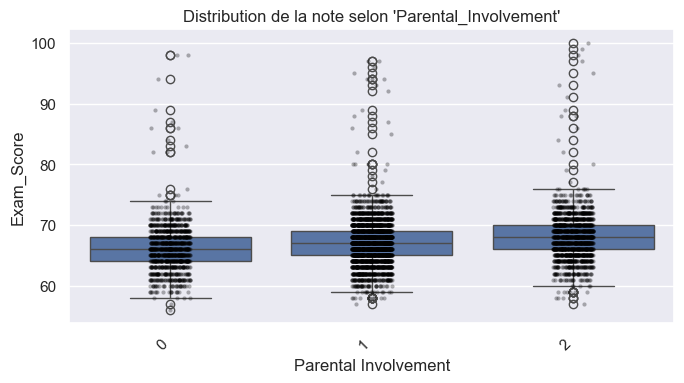

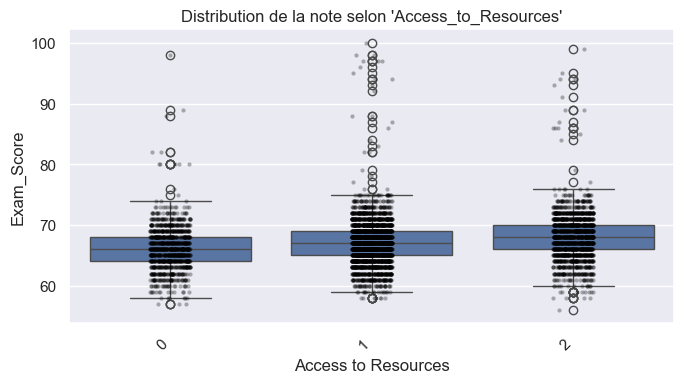

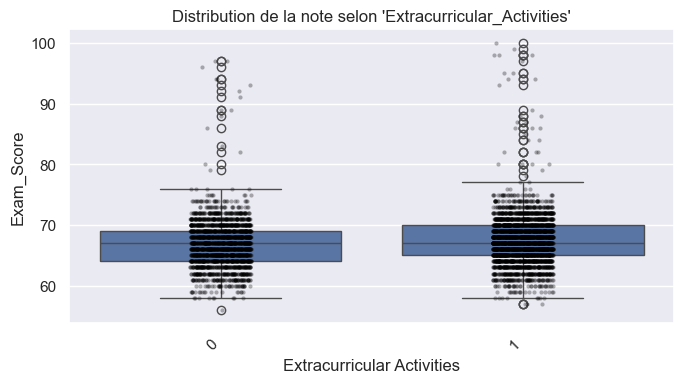

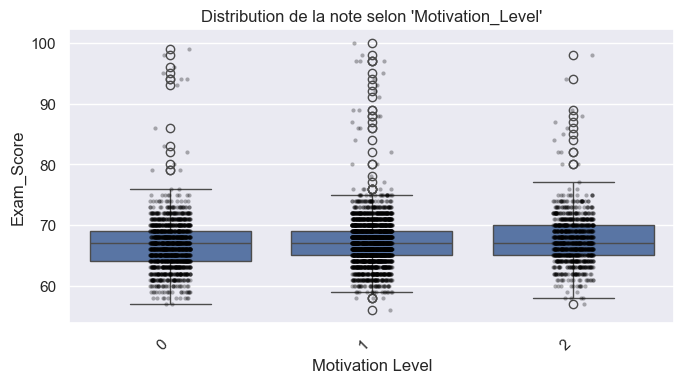

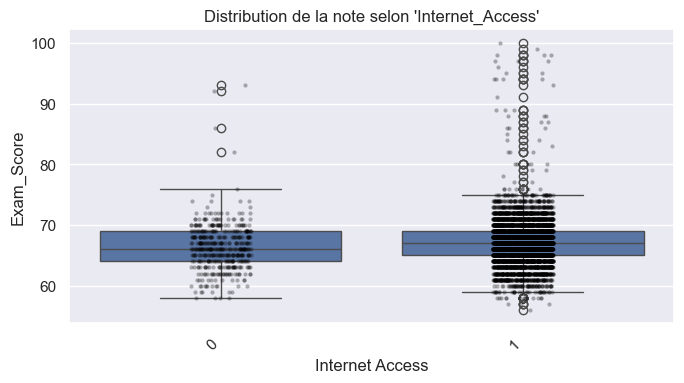

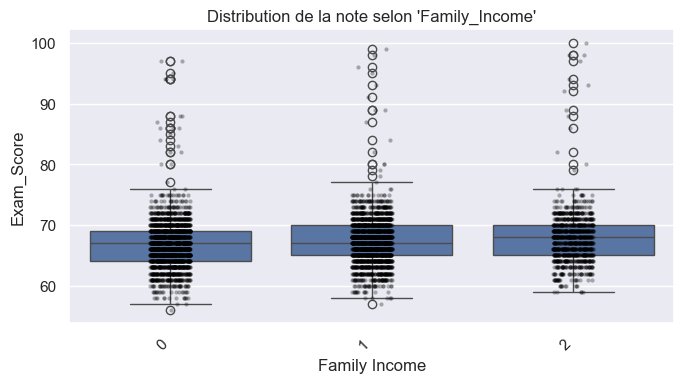

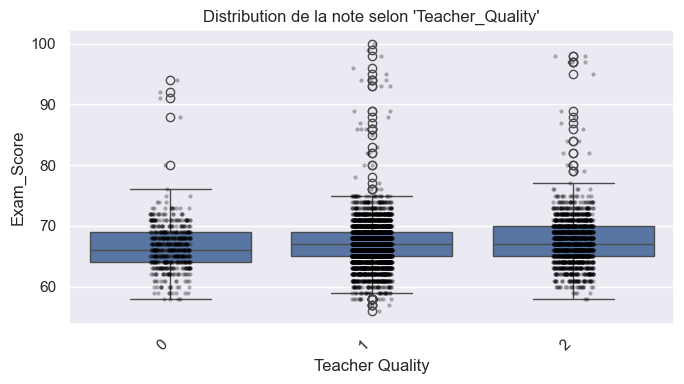

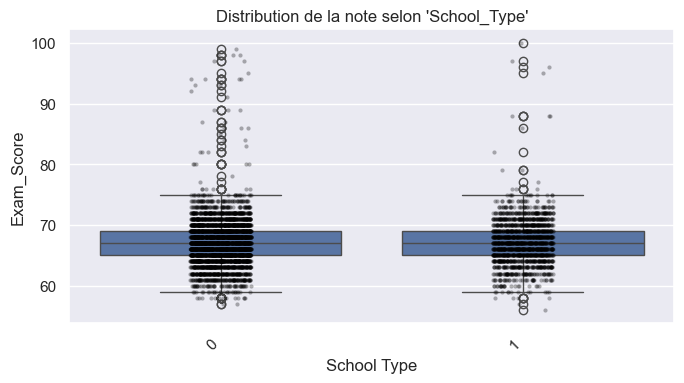

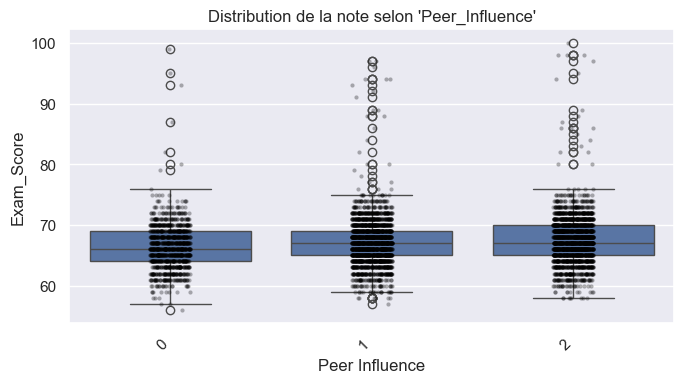

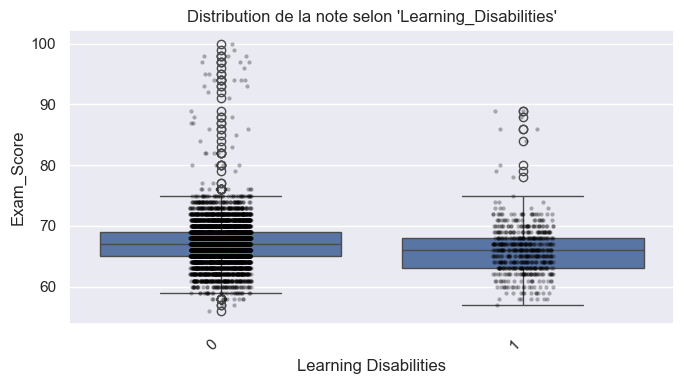

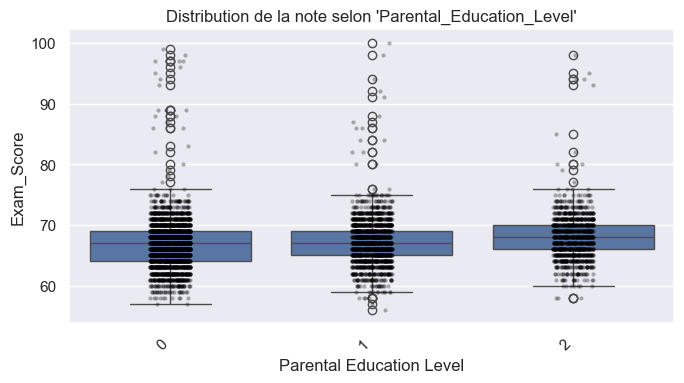

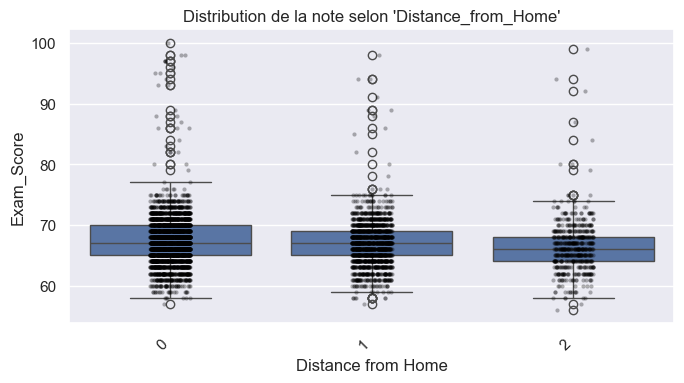

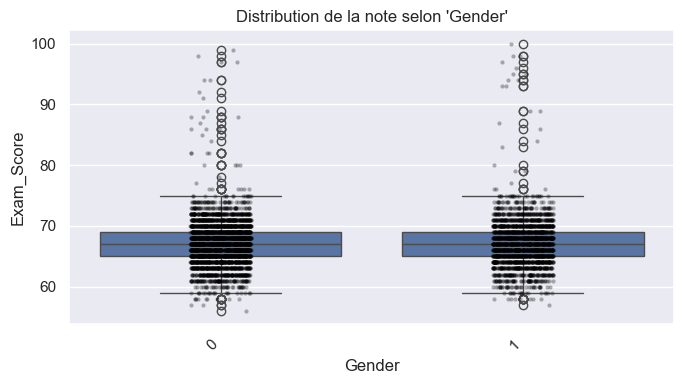

In [318]:
data_quali = pd.read_parquet("../data/clean_df_with_categoricals/")
qualitative_cols = [
    "Parental_Involvement", "Access_to_Resources", "Extracurricular_Activities",
    "Motivation_Level", "Internet_Access", "Family_Income", "Teacher_Quality",
    "School_Type", "Peer_Influence", "Learning_Disabilities",
    "Parental_Education_Level", "Distance_from_Home", "Gender"
]

# --- 2. Tracer un box-plot par variable --------------------------------------
for col in qualitative_cols:
    plt.figure(figsize=(7, 4))
    order = sorted(data_quali[col].dropna().unique())  # assure un ordre stable
    sns.boxplot(data=data_quali, x=col, y="Exam_Score", order=order)
    sns.stripplot(data=data_quali, x=col, y="Exam_Score", order=order,
                  size=3, color="black", alpha=0.3)        # points individuels
    plt.title(f"Distribution de la note selon '{col}'")
    plt.xlabel(col.replace("_", " "))
    plt.ylabel("Exam_Score")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [319]:
# data: pd.DataFrame = pd.read_csv("data/StudentPerformanceFactors.csv") # type: ignore
data = pd.read_parquet("../data/clean_df/")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5915 entries, 0 to 5914
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Hours_Studied      5915 non-null   int32
 1   Attendance         5915 non-null   int32
 2   Sleep_Hours        5915 non-null   int32
 3   Previous_Scores    5915 non-null   int32
 4   Tutoring_Sessions  5915 non-null   int32
 5   Physical_Activity  5915 non-null   int32
 6   Exam_Score         5915 non-null   int32
dtypes: int32(7)
memory usage: 161.9 KB


In [320]:
print(data.shape)
data.describe()

(5915, 7)


,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score
count,5915.000000,5915.000000,5915.000000,5915.000000,5915.000000,5915.000000,5915.000000
mean,19.991040,79.985461,7.040406,75.080473,1.289265,2.962975,67.144379
std,5.822776,11.534313,1.468722,14.362626,0.982435,1.029074,3.844076
min,4.000000,60.000000,4.000000,50.000000,0.000000,0.000000,56.000000
25%,16.000000,70.000000,6.000000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.000000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.000000,88.000000,2.000000,4.000000,69.000000
max,36.000000,100.000000,10.000000,100.000000,3.000000,6.000000,100.000000


array([[<Axes: title={'center': 'Hours_Studied'}>,
        <Axes: title={'center': 'Attendance'}>,
        <Axes: title={'center': 'Sleep_Hours'}>],
       [<Axes: title={'center': 'Previous_Scores'}>,
        <Axes: title={'center': 'Tutoring_Sessions'}>,
        <Axes: title={'center': 'Physical_Activity'}>],
       [<Axes: title={'center': 'Exam_Score'}>, <Axes: >, <Axes: >]],
      dtype=object)

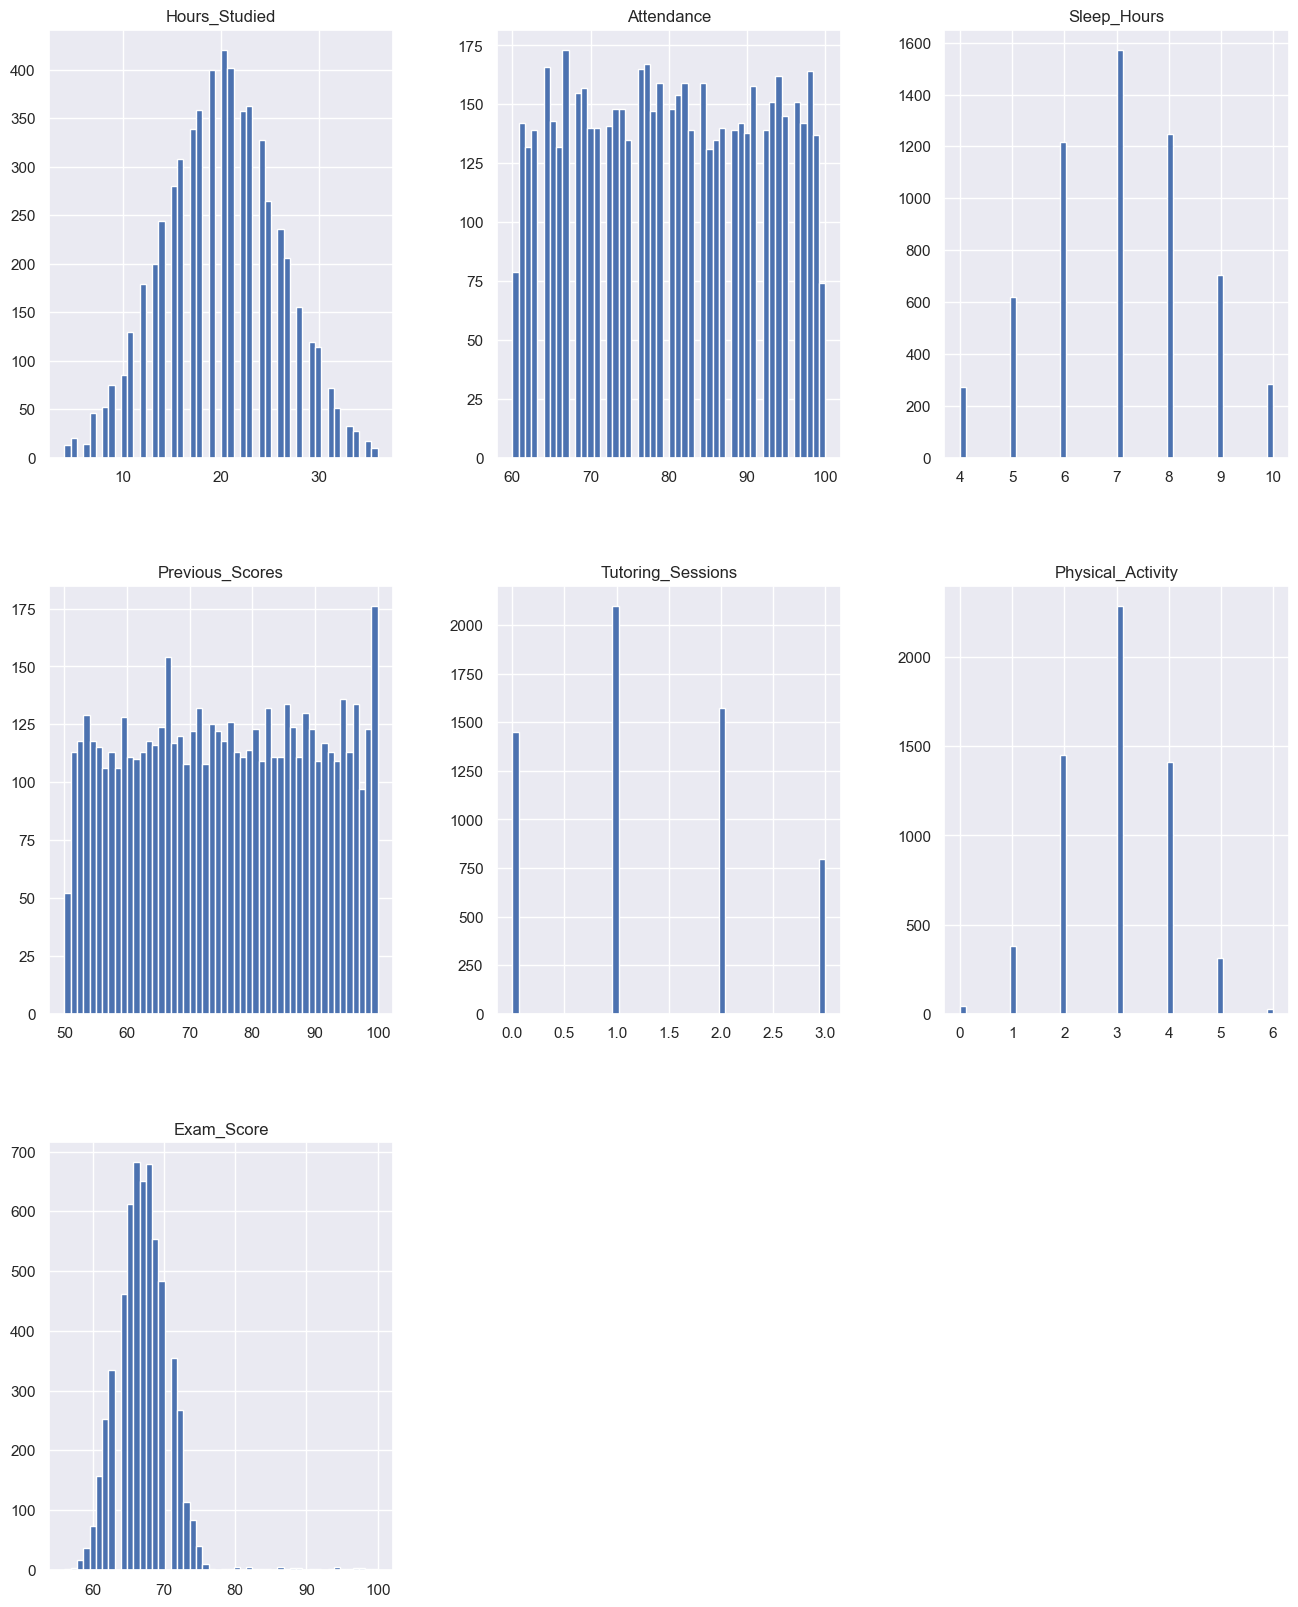

In [321]:
data.hist(figsize=(16,20), bins=50)

<Axes: >

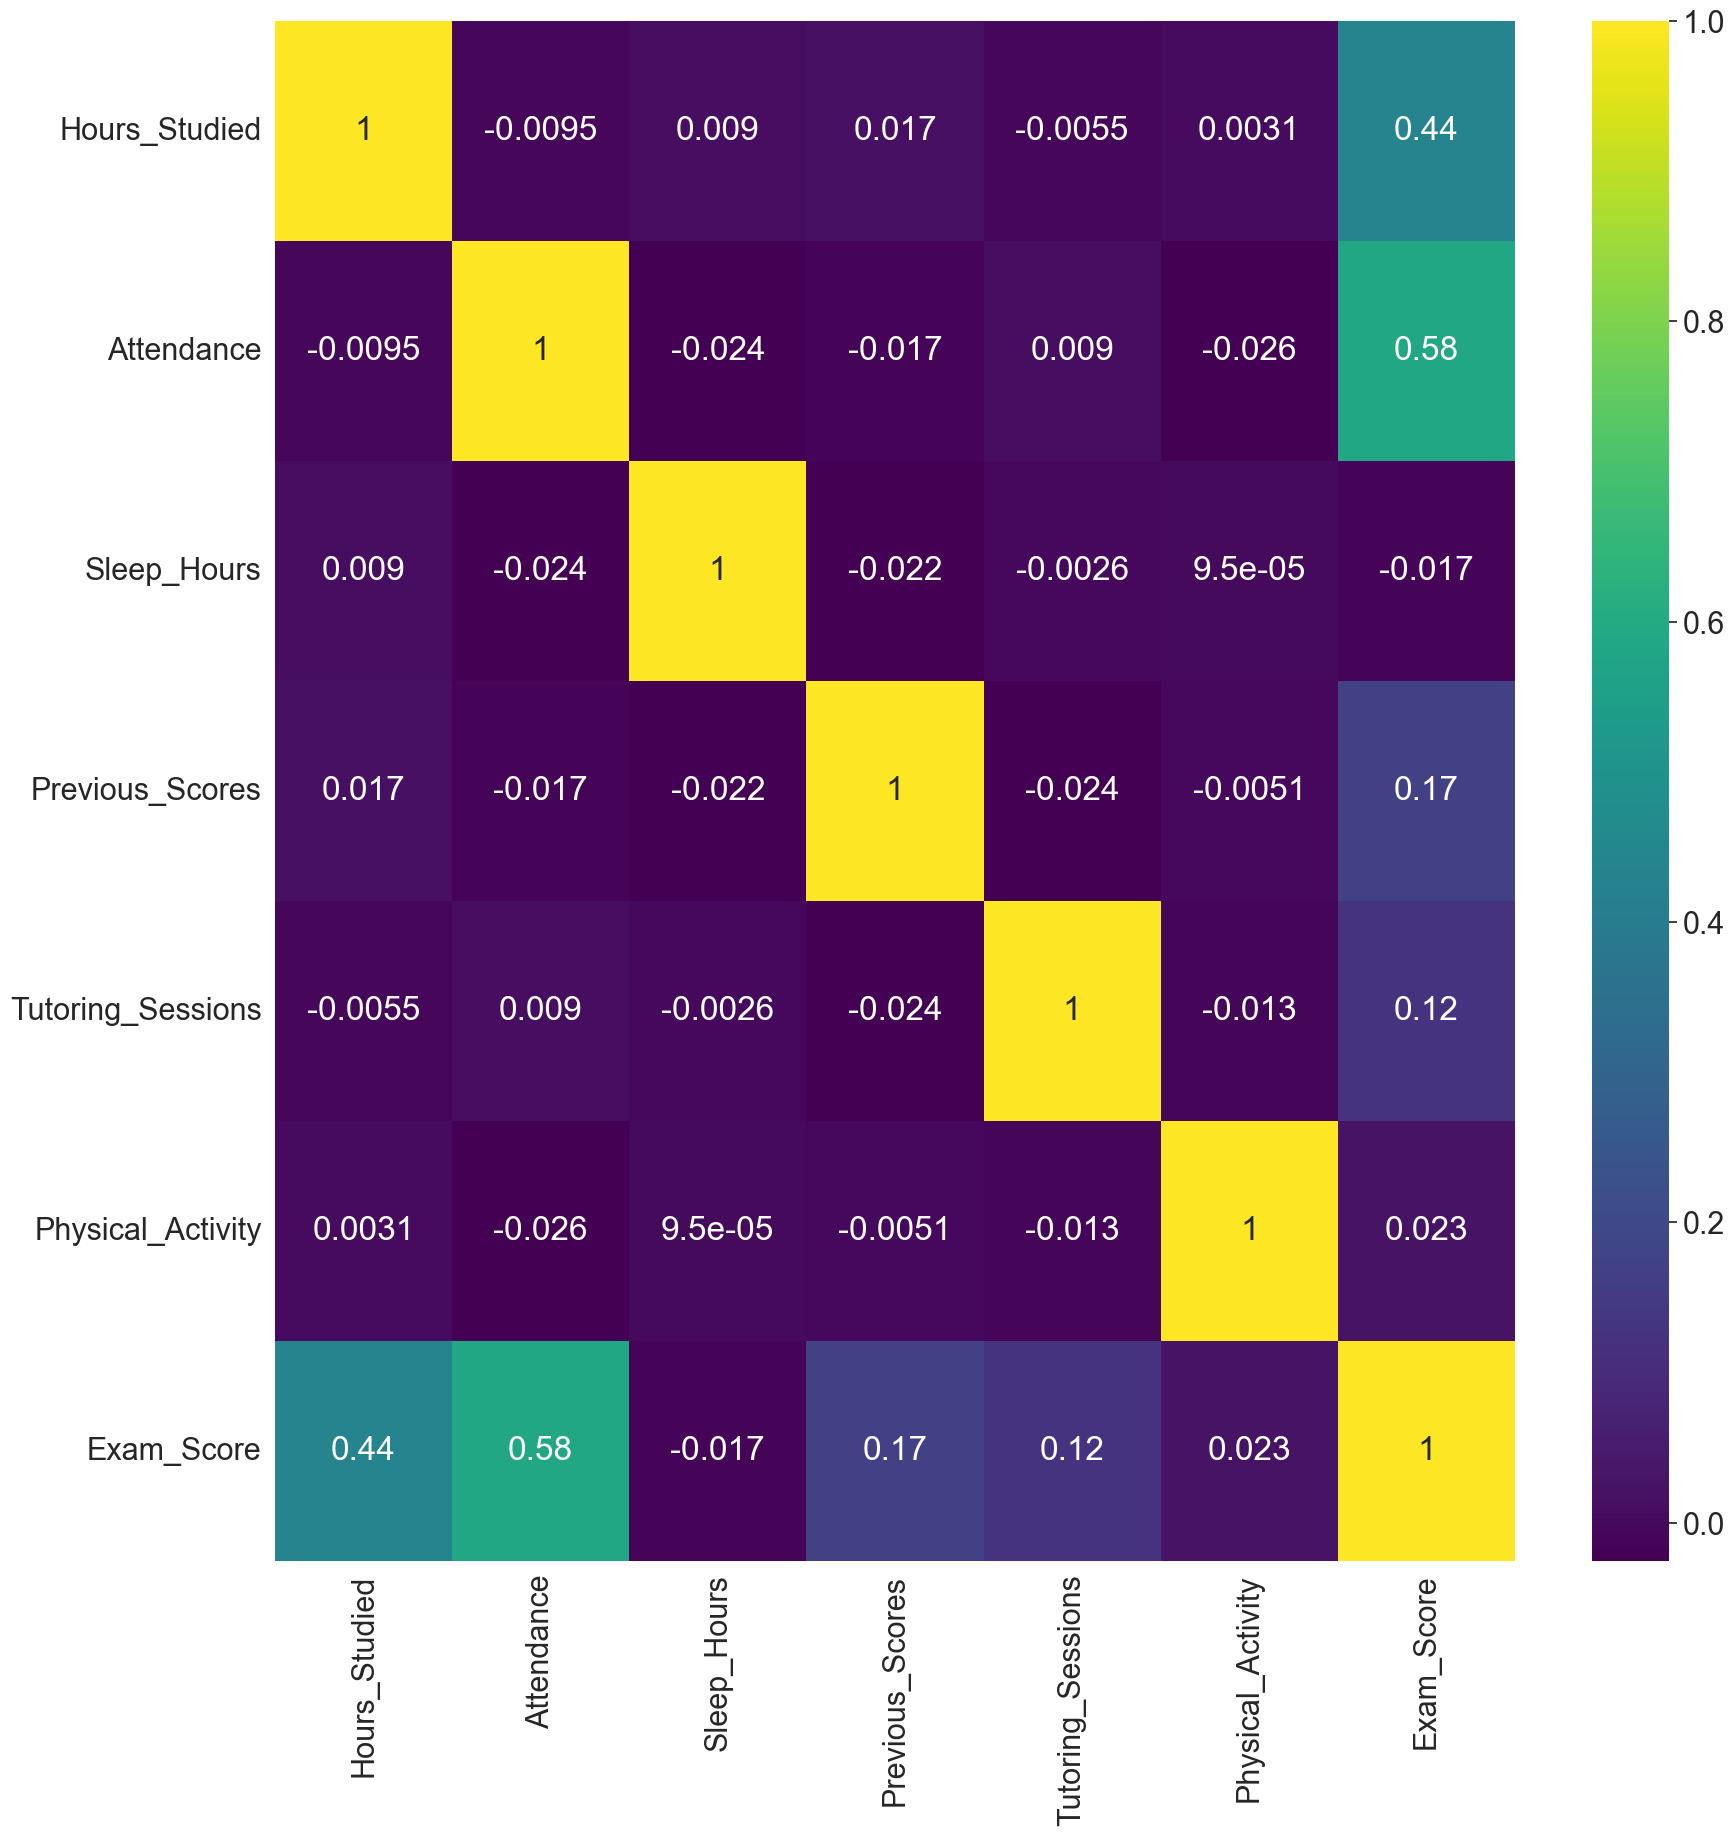

In [322]:
corr = data [['Hours_Studied',
'Attendance',
# 'Parental_Involvement',
# 'Access_to_Resources',
# 'Extracurricular_Activities',
'Sleep_Hours',
'Previous_Scores',
# 'Motivation_Level',
# 'Internet_Access',
'Tutoring_Sessions',
# 'Family_Income',
# 'Teacher_Quality',
# 'School_Type',
# 'Peer_Influence',
'Physical_Activity',
# 'Learning_Disabilities',
# 'Parental_Education_Level',
# 'Distance_from_Home',
# 'Gender',
'Exam_Score']].corr()
plt.figure(figsize=(20,20))
sns.set(style="darkgrid", font_scale=2)
plt.xlabel("",fontsize=20)
plt.ylabel("",fontsize=20)

sns.heatmap(corr, cmap="viridis", annot=True)

In [323]:
sns.set_theme(style='darkgrid')
plt.figure(figsize=(20,10))
# sns.histplot(data['Distance_from_Home'], bins=10, kde=True)

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

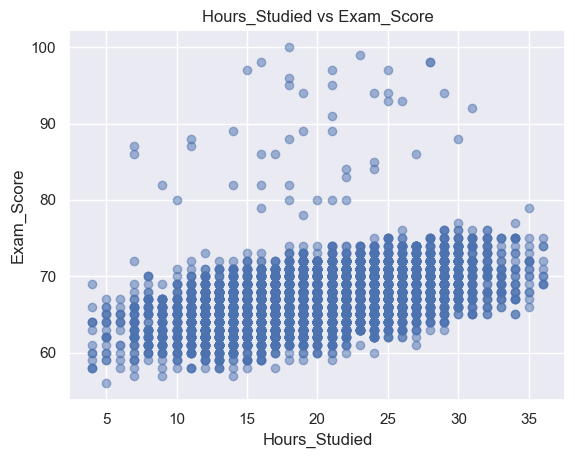

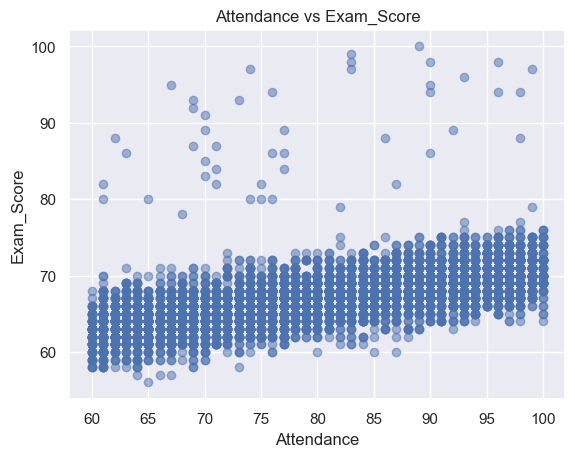

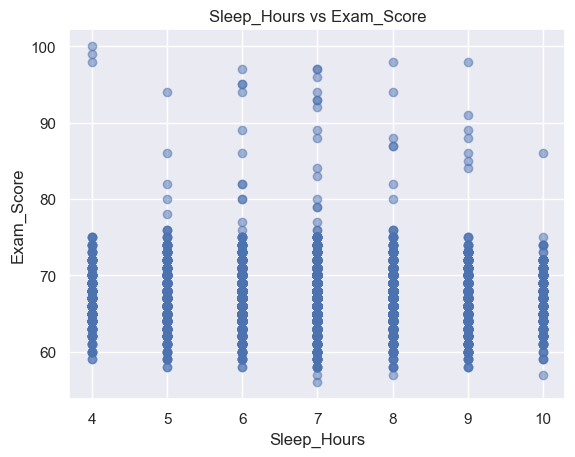

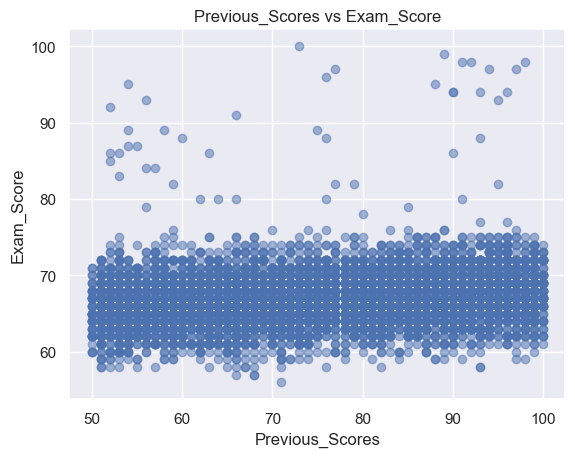

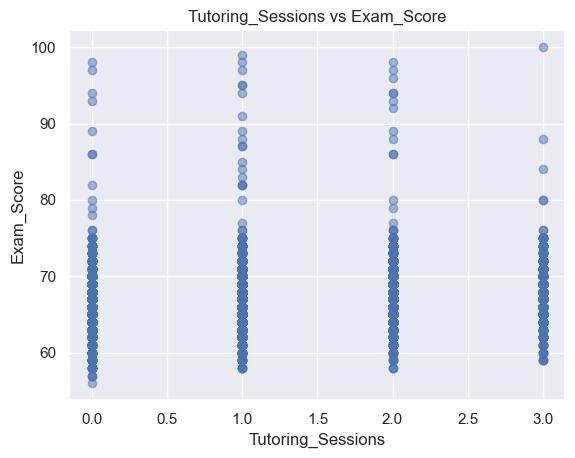

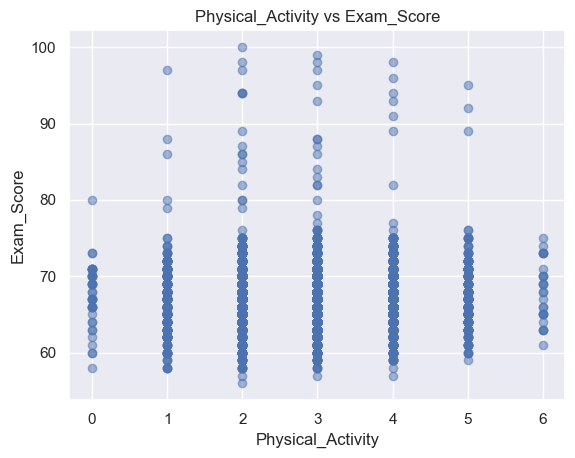

In [ ]:

import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Clustering (hors exam_score)
features = [col for col in data.columns if col != "Exam_Score"]
X = data[features]
kmeans = KMeans(n_clusters=3, random_state=1)
clustering_labels_km = kmeans.fit_predict(X)
data['cluster'] = kmeans.fit_predict(X)

# Visualisation : chaque colonne vs exam_score
for feature in features:
    plt.figure()
    plt.scatter(data[feature], data["Exam_Score"], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel("Exam_Score")
    plt.title(f"{feature} vs Exam_Score")
    plt.show()


In [ ]:
# # Visualisation des clusters
# plt.scatter(X[:,0], X[:,1], c = clustering_labels_km)
# plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='r')

In [325]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.boxplot(x='cluster', y='Exam_Score', data=data)
# plt.title("Distribution de exam_score par cluster")
# plt.xlabel("Cluster")
# plt.ylabel("exam_score")
# plt.show()

# for feature in features:
#     plt.figure()
#     sns.boxplot(x='cluster', y=feature, data=data)
#     plt.title(f"{feature} par cluster")
#     plt.xlabel("Cluster")
#     plt.ylabel(feature)
#     plt.show()

# print(data.groupby('cluster').mean(numeric_only=True))

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

data['label'] = (data['Exam_Score'] > 50).astype(int)


features = [col for col in data.columns if col not in ['Exam_Score', 'label']]
X = data[features]
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)
clf = RandomForestClassifier(random_state=64)
clf.fit(X_train, y_train)
data['y_pred'] = clf.predict(X)

nb_pred_above_50 = (data['y_pred'] == 1).sum()
print(f"Nombre de personnes prédites avec exam_score > 50 : {nb_pred_above_50}")


Nombre de personnes prédites avec exam_score > 50 : 5915


In [326]:

# Créer une copie de X pour X_km
X_km = X.copy()

# Simuler une colonne 'exam_score' (par exemple, une combinaison linéaire + bruit)
np.random.seed(0)
exam_score = 50 + 10*X.iloc[:,0] - 5*X.iloc[:,1] + np.random.normal(0, 1, size=X.shape[0])
X_km['Exam_Score'] = exam_score

# Créer une cible binaire : 1 si exam_score > 50, 0 sinon
X_km['label'] = (X_km['Exam_Score'] > 50).astype(int)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1173
           1       1.00      0.60      0.75        10

    accuracy                           1.00      1183
   macro avg       1.00      0.80      0.87      1183
weighted avg       1.00      1.00      1.00      1183



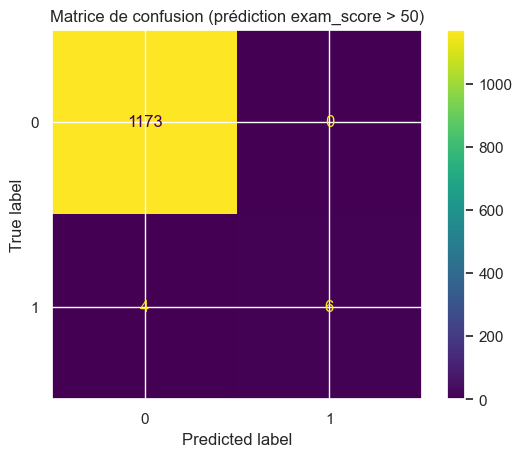

In [327]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Sélection des features (hors clusters, exam_score, label)
features = ['Hours_Studied', 'Attendance', 'Sleep_Hours' , 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']  # les deux premières colonnes de X_km
X_train, X_test, y_train, y_test = train_test_split(
    X_km[features], X_km['label'], test_size=0.2, random_state=64
)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
X_km['y_pred'] = clf.predict(X_km[features])

# Évaluation
print(classification_report(y_test, clf.predict(X_test)))
cm = confusion_matrix(y_test, clf.predict(X_test))
ConfusionMatrixDisplay(cm).plot()
plt.title("Matrice de confusion (prédiction exam_score > 50)")
plt.show()

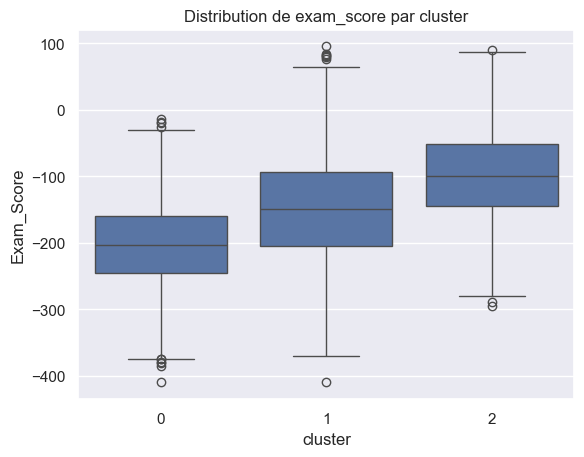

In [328]:
import seaborn as sns

sns.boxplot(x='cluster', y='Exam_Score', data=X_km)
plt.title("Distribution de exam_score par cluster")
plt.show()

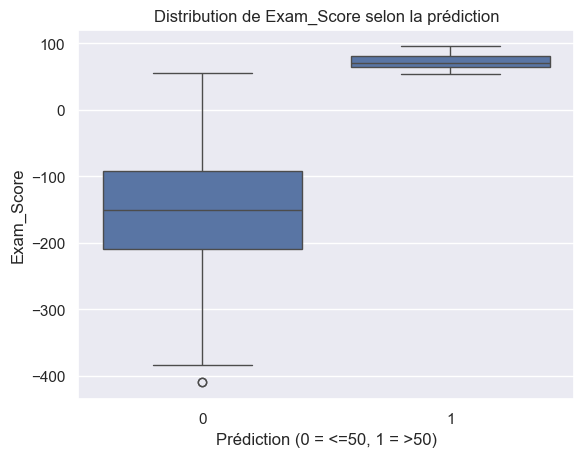

In [329]:
sns.boxplot(x='y_pred', y='Exam_Score', data=X_km)
plt.title("Distribution de Exam_Score selon la prédiction")
plt.xlabel("Prédiction (0 = <=50, 1 = >50)")
plt.show()

In [330]:
print("Nombre de personnes prédites avec exam_score > 50 :", (X_km['y_pred'] == 1).sum())

Nombre de personnes prédites avec exam_score > 50 : 31


In [331]:
seuil = data['Exam_Score'].median()
data['label'] = (data['Exam_Score'] > seuil).astype(int)


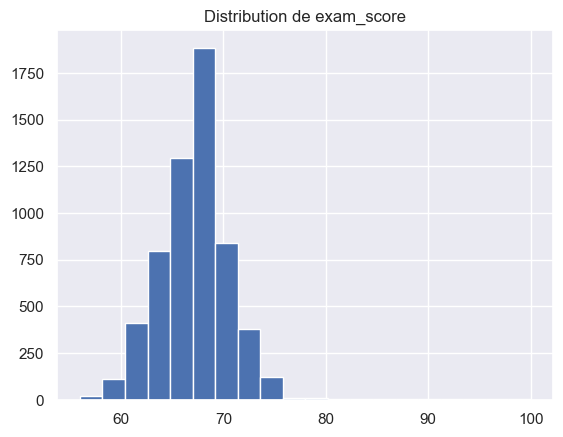

In [332]:
import matplotlib.pyplot as plt
plt.hist(data['Exam_Score'], bins=20)
plt.title("Distribution de exam_score")
plt.show()

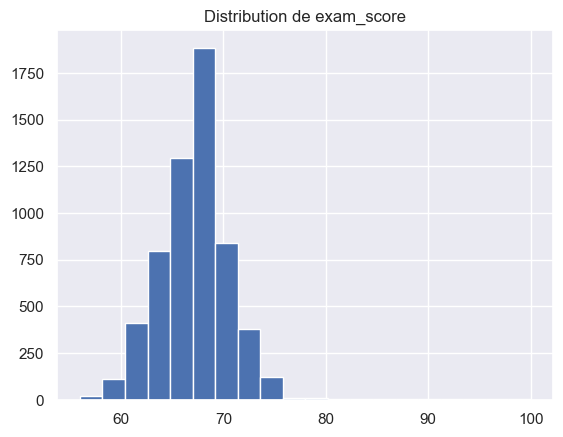

In [333]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(X, columns=['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity'])

# Ajuste les coefficients et le bruit
df['Exam_Score'] = data['Exam_Score']  # Utilise les scores d'examen réels
# Visualise la distribution
plt.hist(df['Exam_Score'], bins=20)
plt.title("Distribution de exam_score")
plt.show()

# Cible binaire équilibrée
seuil = df['Exam_Score'].median()
df['label'] = (df['Exam_Score'] > seuil).astype(int)